## Identifying Age-Related Conditions

Team Members: Akhila Ganti, Megan Nguyen, Leslie Nie, Kevin Stallone, and Tim Tung<br>
Github Repo: https://github.com/UC-Berkeley-I-School/mids-207-final-project-summer23-Tung-Ganti-Nie-Nguyen-Stallone.git

#### ``Project Description``

The goal of this project is to predict if a person has any of three age-related medical conditions. To assess, we will create a model trained on measurements of health characteristics.

#### ``Motivation``
"Aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small."

#### ``Data``
Data is sourced from an active (June 2023) Kaggle competition: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview

### Step 1: Import Libraries

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# ML/stats
from mlxtend.plotting import heatmap
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
%env TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer plots
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

random.seed(2)

env: TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs


### Step 2: Define Functions

In [2]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [36]:
def draw_neural_net(ax, layer_sizes, coefs_, intercepts_,
                    left=0.1, right=.5, bottom=0.1, top=.5):
    '''
    Draw a neural network cartoon using matplotilb.
    Adapted: https://gist.github.com/craffel/2d727968c3aaebd10359
    
    Args:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw=1, head_width=0.01, head_length=0.02)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color='w', ec='k', zorder=4)
            if n == 0:
                plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m+1)+'}$', fontsize=15)
            elif (n_layers == 3) & (n == 1):
                plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m+1)+'}$', fontsize=15)
            elif n == n_layers -1:
                plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m+1)+'}$', fontsize=15)
            ax.add_artist(circle)
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8., color='w', ec='k', zorder=4)
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing-0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.1)*np.sin(rot_mo_rad) + .01
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                plt.text(xm1, ym1,
                         str(round(coefs_[n][m, o],2)),
                         rotation = rot_mo_deg,
                         fontsize = 10)
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        x_bias = (n+0.5)*h_spacing + left
        y_bias = top + 0.005 
        for o in range(layer_size_b):
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c='k')
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.08 * np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 * np.sin(rot_bo_rad)
            plt.text(xo1, yo1,
                 str(round(intercepts_[n][o],2)),
                 rotation = rot_bo_deg,
                 fontsize = 10)    
                
    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)

In [37]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    plt.title('ground truth: ' + str(true_label))
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Step 3: Read Data

In [4]:
# The train.csv file contains 617 observations with 58 features.
# The features are:
#   Id: Unique identifier for each observation.
#   AB-GL: Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
#   Class: A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 
#     0 indicates they have not.

df = pd.read_csv('train.csv')
df.shape

(617, 58)

In [5]:
df.head(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
# The greeks.csv file contains 617 observations with six features.
# The features are:
#   Id: Unique identifier for each observation that matches the Id column in the train.csv file.
#   Alpha Identifies the type of age-related condition, if present.
#   * A: No age-related condition. Corresponds to class 0.
#   * B, D, or G: The three age-related conditions. Correspond to class 1.
#   Beta, Gamma, Delta: Three experimental characteristics.
#   Epsilon The date the data for this subject was collected. Note that all of the data in the test set was 
#   collected after the training set was collected.

df_greeks = pd.read_csv('greeks.csv')
df_greeks.shape

(617, 6)

In [7]:
df_greeks.head(5)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [8]:
# Join the train.csv data with the greeks.csv data so that have all three disease
# conditions in our dataset instead of only the binary values in the Class label.
df = pd.merge(df, df_greeks, on='Id')
df.shape

(617, 63)

In [9]:
df.head(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


### Step 4: Data Preprocessing

``Drop columns that will not be used.``

``Recode class labels``

In [10]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.Alpha))}
class_mapping

df['Alpha'] = df.Alpha.map(class_mapping) # notice how we use all 3 classes
labels = ['Alpha']

# Select only five features (consider reducing to two features for easier visualization in a 2D space)
features = ['AB','AF','CR','DA','DI']

# ansamble data
df = df[labels+features]

# print data and shapes
print('Class labels:', df['Alpha'].unique())
print('Features:', df.columns[1:])
print('Shape of data', df.shape)
df.head()

Class labels: [1 0 2 3]
Features: Index(['AB', 'AF', 'CR', 'DA', 'DI'], dtype='object')
Shape of data (617, 6)


,Alpha,AB,AF,CR,DA,DI
0,1,0.209377,3109.03329,0.069225,69.08340,89.245560
1,0,0.145282,978.76416,1.117800,70.79836,110.581815
2,0,0.470030,2635.10654,0.700350,70.81970,120.056438
3,0,0.252107,3819.65177,0.636075,47.27586,139.824570
4,2,0.380297,3733.04844,0.693150,74.06532,97.920120


``Split data into training and test datasets``

In [11]:
# define outcome #
# The Alpha column includes the ground truth labels.
##################
y = df['Alpha'].values

# define features #
# The feature columns in the dataset include all of the columns except the unique record identifier,
# Class label (binary of whether an age-related condition exists), Alpha (ground truth labels), and Epsilon (date).
###################
X = df[features].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data.
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)

# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=labels+features

Size of X_train (431, 5)
Size of y_train (431,)
Size of X_test (186, 5)
Size of y_test (186,)


### Step 5: Exploratory Data Analysis (EDA)

`` Check if any missing values``

In [12]:
###
### Question: Should we do null analysis on the test dataset as well as the train dataset?
###

df_train.isna().sum()

Alpha    0
AB       0
AF       0
CR       0
DA       0
DI       0
dtype: int64

In [13]:
# Select any rows in the training dataset that have null values in any feature

df_train[df_train.isna().any(axis=1)]

,Alpha,AB,AF,CR,DA,DI


In [14]:
df_train[df_train['BQ'].isna()]

KeyError: 'BQ'

Of the 52 rows that have a null value in any feature, 6 are observations of disease conditions (4 B, 1 D, 1 G) and the balance are healthy observations. At this time, will drop all observations that have any null values in any features, but may want to use a different approach given how few observations we have.

In [16]:
df_train.dropna(axis=0, inplace=True)
df_train

,Alpha,AB,AF,CR,DA,DI
0,0,0.666588,2574.12012,0.723600,40.47228,253.815593
1,0,0.200831,2435.39120,0.798450,98.59080,132.674835
2,0,0.512760,1257.43684,0.655950,57.89736,146.699460
3,0,0.239288,751.02522,0.856650,55.94960,92.539935
4,0,0.495668,4397.13516,0.701550,40.43348,192.677640
...,...,...,...,...,...,...
426,0,0.264926,2384.14044,0.403425,78.98904,201.058530
427,0,0.132463,3427.11930,0.775200,35.63392,233.471415
428,2,0.457211,3347.39966,0.642450,62.79004,90.228225
429,0,0.111098,3798.26986,0.830025,51.71846,131.360850


``check distributions``

using describe()

In [17]:
df_train.describe()

,Alpha,AB,AF,CR,DA,DI
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.285383,0.460631,3520.488170,0.740056,51.400764,147.966859
std,0.718360,0.366477,2357.554344,0.294809,20.491336,93.587275
min,0.000000,0.081187,192.593280,0.069225,7.193520,60.232470
25%,0.000000,0.247834,2198.404230,0.586425,38.301420,102.276225
50%,0.000000,0.354659,3124.575740,0.725775,49.762940,130.468545
75%,0.000000,0.559763,4380.118930,0.855075,61.256470,166.757497
max,3.000000,4.277273,28688.187660,3.039675,190.131640,1049.168078


using hist()

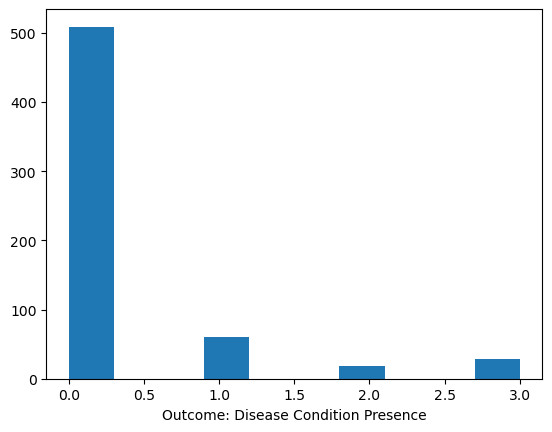

In [18]:
df.Alpha.hist(grid=False)
plt.xlabel('Outcome: Disease Condition Presence');

In [19]:
class_mapping

{'A': 0, 'B': 1, 'D': 2, 'G': 3}

Note that the train dataset is very unbalanced and there are very few obervations of D and G.

IndexError: list index out of range

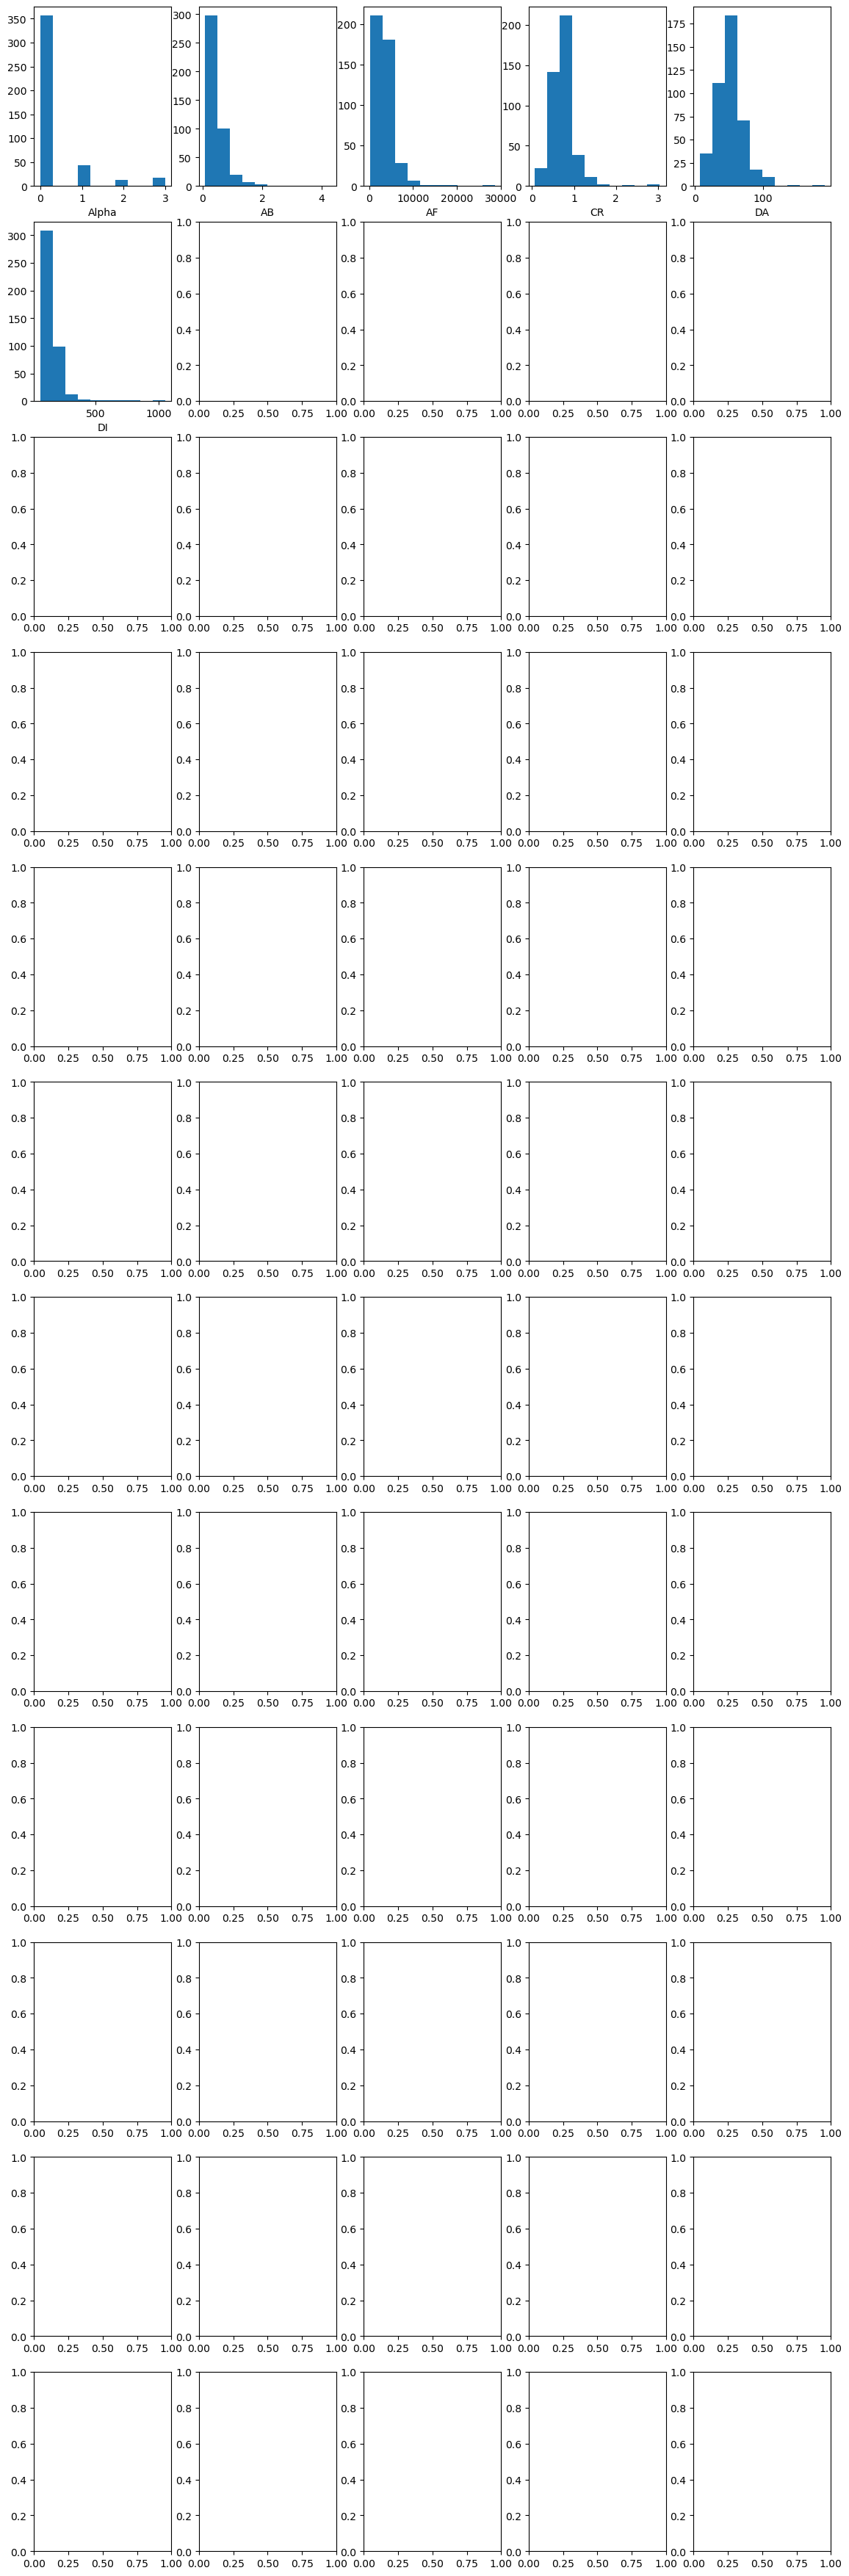

In [21]:
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=12, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

``correlation matrix of outcome and feature variables``

In [22]:
# # Convert the Alpha column to one-hot encodings to assess correlations for each of the three disease conditions.

# # get dummies
# Alpha_dummies = pd.get_dummies(df_train.Alpha)

# # add to initial df
# df_train_corr = df_train.drop(['Alpha'],axis=1)
# df_train_corr = pd.concat((Alpha_dummies, df_train_corr), axis=1)

# # print head of df
# df_train_corr.head()

In [23]:
# Temporarily drop the non-numeric features (EJ, Beta, Gamma, Delta) so that I can run correlations.
df_train_corr = df_train.drop(['EJ','Beta','Gamma','Delta'],axis=1)
df_train_corr

KeyError: "['EJ', 'Beta', 'Gamma', 'Delta'] not found in axis"

In [ ]:
cm = df_train_corr.corr(numeric_only=False).values
hm = heatmap(
    cm,
    row_names=df_train_corr.columns,
    column_names=df_train_corr.columns,
    figsize=(40, 40)
)

### Step 6: Analysis - Logistic Regression with five variables

In [26]:
df_train

,Alpha,AB,AF,CR,DA,DI
0,0,0.666588,2574.12012,0.723600,40.47228,253.815593
1,0,0.200831,2435.39120,0.798450,98.59080,132.674835
2,0,0.512760,1257.43684,0.655950,57.89736,146.699460
3,0,0.239288,751.02522,0.856650,55.94960,92.539935
4,0,0.495668,4397.13516,0.701550,40.43348,192.677640
...,...,...,...,...,...,...
426,0,0.264926,2384.14044,0.403425,78.98904,201.058530
427,0,0.132463,3427.11930,0.775200,35.63392,233.471415
428,2,0.457211,3347.39966,0.642450,62.79004,90.228225
429,0,0.111098,3798.26986,0.830025,51.71846,131.360850


In [27]:
# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

``with TensorFlow``

In [28]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    # create output layer
    model.add(keras.layers.Dense(
          units=4,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remember it's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy']
    )
    return model

# Build a model
model = build_model(num_features=len(features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 4)                 24        
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


Model fit:

In [31]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=20,
                verbose=0 #silence fit
               )

Show learned model

In [32]:
# Show learned model
w = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

Bias: [ 0.22040099 -0.05282808 -0.08839459 -0.0779026 ]
Weights [[-0.03487021  0.01313319 -0.00528631  0.02444323]
 [-0.04463745  0.02717269  0.00756938  0.01743383]
 [ 0.04348031 -0.01626342 -0.00455238 -0.00821978]
 [ 0.022455   -0.0088517  -0.02622543 -0.02958301]
 [-0.02388281  0.01624491  0.01675997  0.02769887]]


Plot model performance:

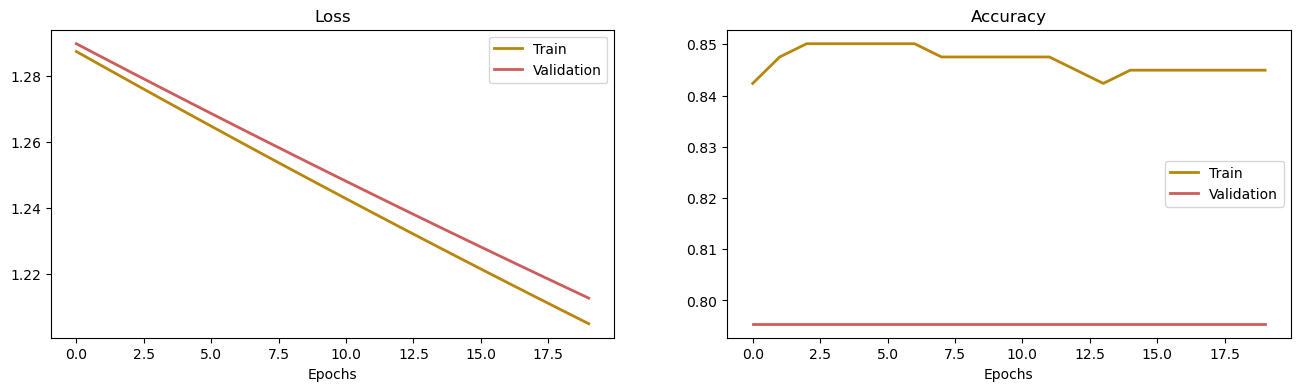

In [33]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

Prediction (on test data)

In [34]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std)

# print the predictions for the first example in test data
y_test_pred_tf[0]

6/6 [==============================] - 0s 0s/step


array([0.3206671 , 0.23288648, 0.22421671, 0.22222973], dtype=float32)

Plot the first 15 examples in the test data, their predicted labels, and the true labels.  Color correct predictions in blue and incorrect predictions in red.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

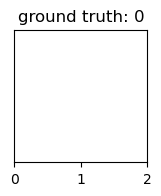

In [39]:
num_rows = 5
num_cols = 3
num_examples = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_examples):
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred_tf[i], y_test) # this function is defined at the top of the notebook
    
plt.tight_layout()
plt.show()

Evaluation (on test data)

In [40]:
# print accuracy for test
y_test_pred_tf = model.predict(x=X_test_std)

# set predicted label based on highest probability
y_test_maxpred_tf =  np.argmax(y_test_pred_tf, axis=1)

print('Test, misclassified examples: %d' % (y_test != y_test_maxpred_tf).sum())
error_test_tf = (y_test != y_test_maxpred_tf).sum()/len(y_test_maxpred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

6/6 [==============================] - 0s 800us/step
Test, misclassified examples: 33
Test, prediction accuracy: 0.823


In [41]:
# plot confusion matrix
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_maxpred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[151,   0,   0,   1],
       [ 16,   0,   0,   2],
       [  1,   0,   0,   4],
       [  8,   1,   0,   2]])>

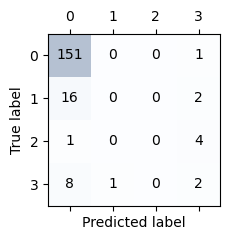

In [42]:
confusion_matrix_plot(conf_matrix.numpy())